In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
warnings.filterwarnings("ignore")

In [ ]:
## Final data frame produced by Kevin... God work.
df = pd.read_pickle('F:////League of legends Game Prediction//LoL-PlaybyPlay-Win-Prediction//data_merged//data_merged//df_final_merge.pkl')

In [274]:
df[(df['matchId']=='NA1_4572960672')&(df['teamIdStr']=='TEAM1')]

,matchId,participantId,sampleTimestamp,currentGold,goldPerSecond,jungleMinionsKilled,level,minionsKilled,timeEnemySpentControlled,totalGold,xp,championStats_abilityHaste,championStats_abilityPower,championStats_armor,championStats_armorPen,championStats_armorPenPercent,championStats_attackDamage,championStats_attackSpeed,championStats_bonusArmorPenPercent,championStats_bonusMagicPenPercent,championStats_ccReduction,championStats_cooldownReduction,championStats_health,championStats_healthMax,championStats_healthRegen,championStats_lifesteal,championStats_magicPen,championStats_magicPenPercent,championStats_magicResist,championStats_movementSpeed,championStats_omnivamp,championStats_physicalVamp,championStats_power,championStats_powerMax,championStats_powerRegen,championStats_spellVamp,damageStats_magicDamageDone,damageStats_magicDamageDoneToChampions,damageStats_magicDamageTaken,damageStats_physicalDamageDone,damageStats_physicalDamageDoneToChampions,damageStats_physicalDamageTaken,damageStats_totalDamageDone,damageStats_totalDamageDoneToChampions,damageStats_totalDamageTaken,damageStats_trueDamageDone,damageStats_trueDamageDoneToChampions,damageStats_trueDamageTaken,position_x,position_y,puuid,teamId,teamIdStr,win,championId,championName,lane,role,teamPosition,INHIBITOR_FINAL_HIT,BASE_TURRET_FINAL_HIT,INNER_TURRET_FINAL_HIT,NEXUS_TURRET_FINAL_HIT,OUTER_TURRET_FINAL_HIT,RUNNING_INHIBITOR_FINAL_HIT,RUNNING_BASE_TURRET_FINAL_HIT,RUNNING_INNER_TURRET_FINAL_HIT,RUNNING_NEXUS_TURRET_FINAL_HIT,RUNNING_OUTER_TURRET_FINAL_HIT,INHIBITOR_TEAM_KILLS,BASE_TURRET_TEAM_KILLS,INNER_TURRET_TEAM_KILLS,NEXUS_TURRET_TEAM_KILLS,OUTER_TURRET_TEAM_KILLS,RUNNING_INHIBITOR_TEAM_KILLS,RUNNING_BASE_TURRET_TEAM_KILLS,RUNNING_INNER_TURRET_TEAM_KILLS,RUNNING_NEXUS_TURRET_TEAM_KILLS,RUNNING_OUTER_TURRET_TEAM_KILLS,KILL_COUNT,RUNNING_KILL_COUNT,DEATH_COUNT,RUNNING_DEATH_COUNT,OBJECTIVE_AIR_DRAGON,OBJECTIVE_BARON_NASHOR,OBJECTIVE_CHEMTECH_DRAGON,OBJECTIVE_EARTH_DRAGON,OBJECTIVE_ELDER_DRAGON,OBJECTIVE_FIRE_DRAGON,OBJECTIVE_HEXTECH_DRAGON,OBJECTIVE_RIFTHERALD,OBJECTIVE_WATER_DRAGON,ITEMS_PURCHASED,TURRET_PLATE_KILL_BOT_LANE,TURRET_PLATE_KILL_MID_LANE,TURRET_PLATE_KILL_TOP_LANE,WARDS_PLACED,dragon_kill,Total_dragon_kill
0,NA1_4572960672,1,0,500,0,0,1,0,0,500,0,0,0,31,0,0,25,100,0,0,0,0,600,600,0,0,0,0,32,345,0,0,280,280,0,0,0,0,0,0,0,0,0,0,0,0,0,0,554,581,B0eXQq2qlmfwRLrLsrU_TvL-rdj5hkl79xGnuQ_kLHRchR...,100.0,TEAM1,True,41.0,Gangplank,MIDDLE,DUO,TOP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NA1_4572960672,2,0,500,0,0,1,0,0,500,0,0,0,36,0,0,25,100,0,0,0,0,640,640,0,0,0,0,32,340,0,0,300,300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,557,345,_mtHAPfy340nqfMITPlfTN7a6PuvXFTkhKE6azH4DSMZ5i...,100.0,TEAM1,True,59.0,JarvanIV,JUNGLE,NONE,JUNGLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NA1_4572960672,3,0,500,0,0,1,0,0,500,0,0,0,23,0,0,25,100,0,0,0,0,600,600,0,0,0,0,30,335,0,0,405,405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,335,269,wUC17OWHaQCnWF0Z7Br22RY5CiFZSJd19C0hhlQLOeclxO...,100.0,TEAM1,True,112.0,Viktor,MIDDLE,DUO,MIDDLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NA1_4572960672,4,0,500,0,0,1,0,0,500,0,0,0,26,0,0,25,100,0,0,0,0,600,600,0,0,0,0,30,335,0,0,349,349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,194,457,fVT0sIesof2Jc0-xZqCbPWlN4D6AGKpSYMBXMM2R9uuLYA...,100.0,TEAM1,True,360.0,Samira,BOTTOM,CARRY,BOTTOM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NA1_4572960672,5,0,500,0,0,1,0,0,500,0,0,0,39,0,0,25,100,0,0,0,0,635,635,0,0,0,0,32,335,0,0,375,375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,329,650,RfvKCjB5C0Kb460KgBMMg7f4IwHScQK6D2lvQcPm7NyJR4...,1

In [8]:
## Cut data into early game stage
## Cut-off standard here: cut off at 20 min, or second dragon killed.
## we might only pick game where game length is > 30 min at least for training. Not implement for now.

df['dragon_kill'] = df['OBJECTIVE_AIR_DRAGON']+df['OBJECTIVE_CHEMTECH_DRAGON']+df['OBJECTIVE_EARTH_DRAGON']+df['OBJECTIVE_FIRE_DRAGON']+df['OBJECTIVE_HEXTECH_DRAGON']
Dragon_Kill = pd.DataFrame(df[['dragon_kill','matchId','sampleTimestamp','teamIdStr']].groupby(['matchId','sampleTimestamp'])['dragon_kill'].sum())
Dragon_Kill = Dragon_Kill.rename(columns={'dragon_kill':'Total_dragon_kill'})
df = df.merge(Dragon_Kill,on = (['matchId','sampleTimestamp']),how='left')

df['Total_dragon_kill'] = df['Total_dragon_kill']/5

time_cutoff = 60000*20
dragon_cutoff = 3
mask1 = df['sampleTimestamp'] < time_cutoff
mask2 = df['Total_dragon_kill']<dragon_cutoff

dfearly = df[(mask1)&(mask2)]

In [9]:
## let's train team 1 first.
T1_dfearly = dfearly[dfearly['teamIdStr']=='TEAM1']
T2_dfearly = dfearly[dfearly['teamIdStr']=='TEAM2']
## check data.
T1_dfearly[(T1_dfearly['matchId']=='NA1_4572960672')][['matchId',
    'participantId','sampleTimestamp',
    'totalGold','Total_dragon_kill','dragon_kill']]

,matchId,participantId,sampleTimestamp,totalGold,Total_dragon_kill,dragon_kill
0,NA1_4572960672,1,0,500,0.0,0.0
1,NA1_4572960672,2,0,500,0.0,0.0
2,NA1_4572960672,3,0,500,0.0,0.0
3,NA1_4572960672,4,0,500,0.0,0.0
4,NA1_4572960672,5,0,500,0.0,0.0
...,...,...,...,...,...,...
190,NA1_4572960672,1,1140000,9389,2.0,0.0
191,NA1_4572960672,2,1140000,6856,2.0,0.0
192,NA1_4572960672,3,1140000,6197,2.0,0.0
193,NA1_4572960672,4,1140000,6150,2.0,0.0


In [482]:
## Total gold should matter here. For each team, we should be able to panelly transform the dataframe to team, sampleTimestamp, and features.
## process totalGold into flat dataframe per game by sampleTimestamp, and add total gold differences between two team by timestamp.

def gold_handler(df):
    process_df = df[['matchId','sampleTimestamp','participantId','totalGold']]
    process_df = process_df.groupby(['matchId','sampleTimestamp','participantId']).first().unstack(level=2).reset_index()
    renamedict = {}
    renamedict[0] = 'matchId'
    renamedict[1] = 'sampleTimestamp'
    for i in range(2,7):
        renamedict[i] ='totalGold_p'+str(i-1)
    return pd.DataFrame(np.array(process_df)).rename(columns = renamedict).set_index(['matchId','sampleTimestamp'])
T1_gold = gold_handler(T1_dfearly)
T2_gold = gold_handler(T2_dfearly)
gold_diff = T1_gold - T2_gold

colrename = {}
for cn in gold_diff.columns:
    colrename[cn] = cn+'_diff'
gold_diff.rename(columns = colrename,inplace =True)
T1_gold = T1_gold.merge(gold_diff,on =['matchId','sampleTimestamp'],how='left')


In [127]:
## Basic data analyais ploting - bucket scatter
def bucket_scatter(df,X,Y,total_bins= 30):
    x = df[X]
    df1 = df[[X,Y]]
    bins = np.geomspace(x.min(),x.max(), total_bins)
    data_cut = pd.cut(df1[X],bins)  
    return df1.groupby(by = data_cut).aggregate(np.mean).plot.scatter(x=X,y=Y)             

#### According to the graph, it's pretty clear that we couldn't extract any information from xp, if we only focusing on early game.

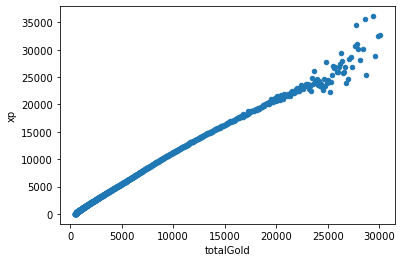

In [135]:
## xp is highly corerlated to gold. Differences show up in late game only
test = bucket_scatter(df,'totalGold','xp',total_bins =1000)

In [ ]:
## AttackDamage.
test = bucket_scatter(df,'totalGold','xp',total_bins =1000)

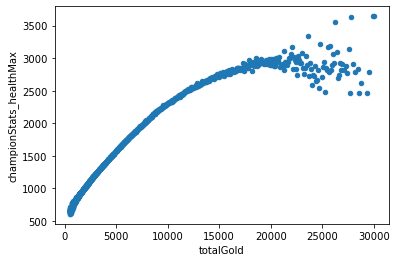

In [138]:
test = bucket_scatter(df,'totalGold', 'championStats_healthMax',total_bins =1000)

In [487]:
## value base features.
charfeatures = ['damageStats_totalDamageTaken','damageStats_totalDamageDoneToChampions','championStats_movementSpeed',
                'championStats_magicResist','championStats_magicPenPercent','championStats_healthMax','championStats_ccReduction',
                'championStats_attackSpeed','championStats_attackDamage','championStats_armor','championStats_abilityPower']

##testset
#charfeatures = ['damageStats_totalDamageDoneToChampions','damageStats_totalDamageTaken']

def champ_char_handler(df,char):
    process_df = df[['matchId','sampleTimestamp','participantId',char]]
    process_df = process_df.groupby(['matchId','sampleTimestamp','participantId']).first().unstack(level=2).reset_index()
    renamedict = {}
    renamedict[0] = 'matchId'
    renamedict[1] = 'sampleTimestamp'
    for i in range(2,7):
        renamedict[i] =str(char)+'_p'+str(i-1)
    return pd.DataFrame(np.array(process_df)).rename(columns = renamedict).set_index(['matchId','sampleTimestamp'])

def champ_char_diff_handler(df1,df2):
    diff = df1-df2
    colrename = {}
    for cn in diff.columns:
        colrename[cn] = cn+'_diff'
    diff.rename(columns = colrename,inplace =True)
    return diff

feature_storage = {}
for datacolumn in charfeatures:
    T1_df = champ_char_handler(T1_dfearly,datacolumn)
    T2_df = champ_char_handler(T2_dfearly,datacolumn)
    data_diff = champ_char_diff_handler(T1_df,T2_df)
    feature_storage[datacolumn] = T1_df.merge(data_diff,on =['matchId','sampleTimestamp'],how='left')

In [488]:
## Feature discretionary mapping

def player_filtering(dicts,features,player_list):
    test = list(feature_storage[features].columns)
    masks = [any(c in L for c in player_list) for L in test]
    newcol = feature_storage[features].columns[[masks]]
    return feature_storage[features][newcol]

feature_mapping = {'damageStats_totalDamageTaken': ('p1','p2','p5'),
                  'damageStats_totalDamageDoneToChampions':('p1','p2','p3','p4','p5'),
                  'championStats_movementSpeed':('p2','p3','p5'),
                  'championStats_healthMax':('p1','p5'),
                  'championStats_attackSpeed':('p4'),
                  'championStats_attackDamage':('p4'),
                  'championStats_armor':('p1','p2','p5'),
                  'championStats_abilityPower':('p3','p5')}

## test
#feature_mapping = {'damageStats_totalDamageTaken': ('p1','p2','p3','p4','p5'),
#                  'damageStats_totalDamageDoneToChampions':('p1','p2','p3','p4','p5')}


for features in feature_mapping:
    feature_storage[features] =player_filtering(feature_storage,features,feature_mapping[features])

In [489]:
## categorical features - we could maybe directly use them?
categorical_feature = df[['matchId','sampleTimestamp','TURRET_PLATE_KILL_BOT_LANE','TURRET_PLATE_KILL_MID_LANE','TURRET_PLATE_KILL_TOP_LANE','dragon_kill']]
categorical_feature = categorical_feature.groupby(['matchId','sampleTimestamp']).first()
categorical_feature

TURRET_PLATE_KILL_BOT_LANE  \
matchId        sampleTimestamp                               
NA1_4459931201 0                                       0.0   
               60000                                   0.0   
               120000                                  0.0   
               180000                                  0.0   
               240000                                  0.0   
...                                                    ...   
NA1_4592506957 720000                                  1.0   
               780000                                  1.0   
               840000                                  1.0   
               900000                                  1.0   
               920000                                  1.0   

                                TURRET_PLATE_KILL_MID_LANE  \
matchId        sampleTimestamp                               
NA1_4459931201 0                                       0.0   
               60000                                   0.0   
               120000                                  0.0   
               180000                                  0.0   
               240000                                  0.0   
...                                                    ...   
NA1_4592506957 720000                                  0.0   
               780000                                  0.0   
               840000                                  0.0   
               900000                                  0.0   
               920000                                  0.0   

                                TURRET_PLATE_KILL_TOP_LANE  dragon_kill  
matchId        sampleTimestamp                                           
NA1_4459931201 0                                       0.0          0.0  
               60000                                   0.0          0.0  
               120000                                  0.0          0.0  
               180000                                  0.0          0.0  
               240000                                  0.0          0.0  
...                                                    ...          ...  
NA1_4592506957 720000                                  0.0          0.0  
               780000                                  0.0          0.0  
               840000                                  0.0          0.0  
               900000                                  0.0          0.0  
               920000                                  0.0          0.0  

[289045 rows x 4 columns]

In [490]:
## Creating full timestamp data Frame
sampleTS = pd.DataFrame({'sampleTimestamp':list(set(T1_dfearly['sampleTimestamp']))}).sort_values(['sampleTimestamp'])
matchId = pd.DataFrame({'matchId':list(set(T1_dfearly['matchId']))}).sort_values(['matchId'])
fullXdf = matchId.merge(sampleTS,how='cross')

In [491]:
## Creating Value_Feature, Linear Interpolation
for features in feature_mapping:
    Xdf = feature_storage[features]
    fullXdf = fullXdf.merge(Xdf.reset_index(),on =['matchId','sampleTimestamp'],how='left').set_index(['matchId','sampleTimestamp'])

fullXdf = fullXdf.merge(T1_gold,on =['matchId','sampleTimestamp'],how='left')
    
for col in fullXdf:
    fullXdf[col] = pd.to_numeric(fullXdf[col], errors='coerce')

gb = fullXdf.groupby('matchId')
Value_Feature = np.array([gb.get_group(x).interpolate(method ='linear', limit_direction ='forward').to_numpy() for x in gb.groups])

In [492]:
fullXdf 

damageStats_totalDamageTaken_p1  \
matchId        sampleTimestamp                                    
NA1_4459931201 0                                            0.0   
               60000                                        0.0   
               100000                                       NaN   
               110000                                       NaN   
               120000                                     164.0   
...                                                         ...   
NA1_4592506957 1150000                                      NaN   
               1160000                                      NaN   
               1170000                                      NaN   
               1180000                                      NaN   
               1190000                                      NaN   

                                damageStats_totalDamageTaken_p2  \
matchId        sampleTimestamp                                    
NA1_4459931201 0                                            0.0   
               60000                                        0.0   
               100000                                       NaN   
               110000                                       NaN   
               120000                                     409.0   
...                                                         ...   
NA1_4592506957 1150000                                      NaN   
               1160000                                      NaN   
               1170000                                      NaN   
               1180000                                      NaN   
               1190000                                      NaN   

                                damageStats_totalDamageTaken_p5  \
matchId        sampleTimestamp                                    
NA1_4459931201 0                                            0.0   
               60000                                      185.0   
               100000                                       NaN   
               110000                                       NaN   
               120000                                     185.0   
...                                                         ...   
NA1_4592506957 1150000                                      NaN   
               1160000                                      NaN   
               1170000                                      NaN   
               1180000                                      NaN   
               1190000                                      NaN   

                                damageStats_totalDamageTaken_p1_diff  \
matchId        sampleTimestamp                                         
NA1_4459931201 0                                                 0.0   
               60000                                             0.0   
               100000                                            NaN   
               110000                                            NaN   
               120000                                         -223.0   
...                                                              ...   
NA1_4592506957 1150000                                           NaN   
               1160000                                           NaN   
               1170000                                           NaN   
               1180000                                           NaN   
               1190000                                           NaN   

                                damageStats_totalDamageTaken_p2_diff  \
matchId        sampleTimestamp                                         
NA1_4459931201 0                                                 0.0   
               60000                                             0.0   
               100000                                            NaN   
               110000                                            NaN   
               120000                          

In [493]:
## Create categorical_feature, fill by data from last timestamp[Padding]
Categorical_feature = fullXdf.merge(categorical_feature.reset_index(),on =['matchId','sampleTimestamp'],how='left').set_index(['matchId','sampleTimestamp'])
Categorical_feature = Categorical_feature.groupby(['matchId'])[list(categorical_feature.columns)].ffill()
gb = Categorical_feature.groupby('matchId')
Categorical_feature = np.array([gb.get_group(x).to_numpy() for x in gb.groups])

In [494]:
Categorical_feature.shape

(10334, 97, 4)

In [495]:
X = np.dstack((Value_Feature,Categorical_feature))
X = X.astype(np.float32)

In [496]:
X.shape

(10334, 97, 70)

In [497]:
## Define Y Variable
YVariable = fullXdf.reset_index().groupby('matchId').first().reset_index()[['matchId']]
YVariable = YVariable.merge(T1_dfearly[['matchId','win']].groupby('matchId').first(),on='matchId',how='left')
Y = np.array(YVariable['win'])
Y = Y.astype(np.float32)

In [498]:
## Train test split
features_train, features_test, targets_train, targets_test = train_test_split(X,
                                                                             Y,
                                                                             test_size = 0.3,
                                                                             random_state = 42) 
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy( targets_test).type(torch.LongTensor) 
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

In [499]:
## Helper function.
def plot_roc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [500]:
# Define LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).float().to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).float().to(x.device)
        out, _ = self.lstm(x.float(), (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

In [514]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define LSTM model parameters
input_size = 70   
hidden_size = 256
num_classes = 2  
learn_rate = 0.02
batch_sizes = 500
num_epochs = 30

## Define Data Loader
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_sizes, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_sizes, shuffle=False)


# Define LSTM model
model = LSTMClassifier(input_size, hidden_size, num_classes)
model.to(device)

# Define loss function and optimizer - we use cross entropy here.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

Epoch 1/30: train loss=0.6578, test loss=0.6364
Epoch 2/30: train loss=0.6227, test loss=0.6161
Epoch 3/30: train loss=0.6045, test loss=0.6010
Epoch 4/30: train loss=0.5938, test loss=0.5944
Epoch 5/30: train loss=0.5867, test loss=0.5909
Epoch 6/30: train loss=0.5785, test loss=0.5770
Epoch 7/30: train loss=0.5743, test loss=0.5744
Epoch 8/30: train loss=0.5708, test loss=0.5734
Epoch 9/30: train loss=0.5641, test loss=0.5625
Epoch 10/30: train loss=0.5601, test loss=0.5597
Epoch 11/30: train loss=0.5528, test loss=0.5557
Epoch 12/30: train loss=0.5537, test loss=0.5498
Epoch 13/30: train loss=0.5506, test loss=0.5525
Epoch 14/30: train loss=0.5476, test loss=0.5507
Epoch 15/30: train loss=0.5455, test loss=0.5486
Epoch 16/30: train loss=0.5456, test loss=0.5465
Epoch 17/30: train loss=0.5439, test loss=0.5493
Epoch 18/30: train loss=0.5467, test loss=0.5503
Epoch 19/30: train loss=0.5444, test loss=0.5402
Epoch 20/30: train loss=0.5347, test loss=0.5431
Epoch 21/30: train loss=0.534

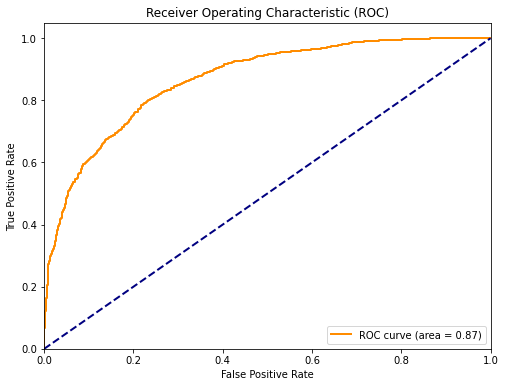

Epoch 30/30: train loss=0.5304, test loss=0.5353


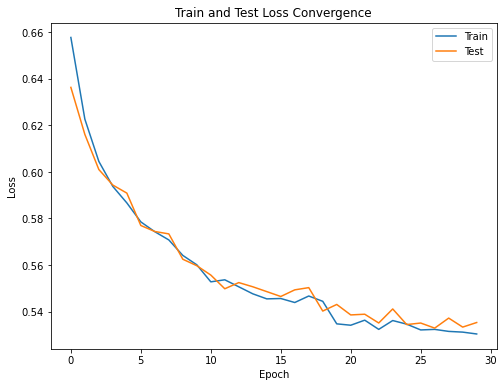

In [515]:
# Training loop
train_losses = []
test_losses = []

# Train LSTM model
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.double().to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        y_true = []
        y_pred = []
        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.double().to(device)
            targets = targets.to(device)
            output = model(inputs)

            # Compute loss
            loss = criterion(output, targets)
            test_loss += loss.item()

            # Collect predictions and true labels for ROC curve
            y_pred.extend(output.detach().numpy()[:, 1])
            y_true.extend(targets.detach().numpy())

        # Compute average loss for the test set
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        # Plot ROC curve
        
        if epoch == num_epochs-1:
            plot_roc(y_true, y_pred)

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}: train loss={epoch_loss:.4f}, test loss={test_loss:.4f}")

    
# Plot train and test loss convergence
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Convergence')
plt.legend()
plt.show()

In [517]:
# Test
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.double().to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
print(f"Test accuracy: {(100 * correct / total):.2f}%")

Test accuracy: 77.23%
